# QBO in OpenIFS 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean 
from scipy.stats import linregress

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34021 instead
  http_address["port"], self.http_server.port


In [4]:
client

Client Scheduler: tcp://127.0.0.1:43919 Dashboard: http://127.0.0.1:34021/status,Cluster Workers: 4 Cores: 8 Memory: 64.00 GB


In [5]:
exp_list = ['focioifs-merge14']

In [6]:
# OpenIFS surface
ds_sfc_all = []
for exp in exp_list:
    sfc = '/data/user/jkjellsson/esm-experiments/focioifs/%s/outdata/oifs/*1m*regular_sfc.nc' % (exp,)
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords').rename({'time_counter':'time'})
    ds_sfc_all.append(ds_sfc)

In [7]:
# OpenIFS plev
ds_pl_all = []
for exp in exp_list:
    pl = '/data/user/jkjellsson/esm-experiments/focioifs/%s/outdata/oifs/*1m*regular_pl.nc' % (exp,)
    ds_pl = xr.open_mfdataset(pl,combine='by_coords').rename({'time_counter':'time'})
    ds_pl_all.append(ds_pl)

In [15]:
# ERA Interim
era = '/data/user/swahl/reanalysis_obs/era40-int/pressure_levels/u/u-eraint-37plevels-monthly-1979-20190228.nc'
ds_pl_ei = xr.open_dataset(era)
u_pl_ei = ds_pl_ei['U']

## Upper-air zonal winds

/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


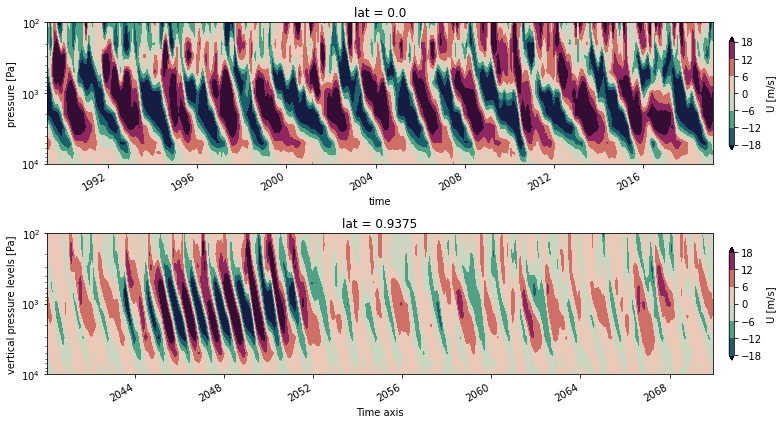

In [23]:
# Plot settings
umin1 = -18
umax1 = 18
ulevels1 = np.linspace(umin1,umax1,7)

cmap1 = cmocean.cm.curl

fig1,axs1 = plt.subplots(len(ds_pl_all)+1,1,figsize=(12,6))

# Zonal mean zonal equatorial wind
u_zt = u_pl_ei[-360:].sel(lat=0,method='nearest').mean('lon')
# Remove seasonal cycle
u_zt_a = u_zt.groupby('time.month') - u_zt.groupby('time.month').mean('time')
ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'U [m/s]', 'orientation':'vertical'}
u_zt_a.plot.contourf(x='time',y='lev',ax=axs1[0],levels=ulevels1,cmap=cmap1,cbar_kwargs=ckw)
    
for j in range(0,len(ds_pl_all)):
    i = j+1
    exp = exp_list[j]
    ds_pl = ds_pl_all[j]
    
    # Zonal mean zonal equatorial wind
    u_zt = ds_pl['u'][-360:].sel(lat=0,method='nearest').mean('lon')
    
    # Remove seasonal cycle
    u_zt_a = u_zt.groupby('time.month') - u_zt.groupby('time.month').mean('time')
    
    ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'U [m/s]', 'orientation':'vertical'}
    u_zt_a.plot.contourf(x='time',y='pressure_levels',ax=axs1[i],levels=ulevels1,cmap=cmap1,cbar_kwargs=ckw)

for ax in axs1:
    ax.set_yscale('log')
    ax.set_ylim([100,10000])
    ax.invert_yaxis()

fig1.tight_layout()
fig1.savefig('qbo_%s_erai.png' % (exp,),format='png')

## Surface pressure and zonal wind

## Winds

## Temperature biases